In [1]:
from fbprophet import Prophet

In [2]:
# ?Prophet

In [3]:
from neuralprophet import NeuralProphet

In [4]:
# ?NeuralProphet

In [5]:
import pandas as pd

from timemachines.skatertools.data.real import hospital_with_exog, hospital
from timemachines.skaters.nproph.nprophskaterfactory import fbnprophet_skater_factory
from timemachines.skatertools.utilities.nonemath import nearlysame
from timemachines.skaters.nproph.nprophiskaterfactory import (
    nprophet_iskater_factory,
    nprophet_fit_and_predict_simple, 
    nprophet_fit_and_predict_with_time,
    nprophet_fit_and_predict_with_time_and_advance_time,
    nprophet_fit_and_predict_with_advance_vars, 
    nprophet_fit_and_predict_with_exog_and_advance_vars,
    nprophet_fit_and_predict_with_exog_and_advance_vars_no_t
)
from timemachines.skaters.nproph.nprophparams import (
    NPROPHET_MODEL, NPROPHET_META)

from timemachines.skatertools.utilities.epochtime import (
    infer_freq_from_epoch, is_valid_freq, epoch_to_naive_datetime, EPOCH)


def get_dataset(k, n):
    y, a = hospital_with_exog(k=k, n=n)
    y = y[:-k]
    t = [i * 15 * 50 for i in range(len(y) + k)]
    if t is None:
        if freq is None or not freq:
            freq = NPROPHET_META['freq']  # Just assume away ...
        else:
            assert is_valid_freq(freq), 'Freq ' + str(freq) + ' is not a valid frequency'
        dt = pd.date_range(start=EPOCH, periods=len(y), freq=freq)  # UTC
    else:
        freq = infer_freq_from_epoch(t)
        print('infering freq param as {}'.format(freq))
        dt = epoch_to_naive_datetime(t)

    if len(dt) == len(y) + k:
        ta = dt
        dt = dt[:len(y)]
    else:
        assert len(dt) == len(y), 'Time vector t should be len(y) or len(y)+k'
        ta = None

    # Massage data into Prophet friendly dataframe with columns y, y1, ..., yk, a0,...aj
    y_cols = ['y' + str(i) if i > 0 else 'y' for i in range(len(y[-1]))]
    if a:
        # TODO: Implement names as args
        a_cols = ['a' + str(i) for i in range(len(a[-1]))] 
        data = [
            list(yi) + list(ai) 
            for yi, ai
            in zip(y, a[:-k])
        ]
        df = pd.DataFrame(columns=y_cols+a_cols, data=data)
    else:
        data = [list(yi) for yi in y]
        df = pd.DataFrame(columns=y_cols, data=data)

    df['ds'] = dt
    return df,freq


In [6]:
from ray import tune

sweep_config = {
    'epochs': tune.grid_search([300]),
    'k': tune.grid_search([1,2,4,8,12,16]),
    'n': tune.grid_search([100, 500, 1000]),
    'n_lags': tune.grid_search([1, 2, 4, 8, 16, 32, 64]),
}

In [7]:
def training_function(model_params):
    # Hyperparameters
    df,freq = get_dataset(k=model_params['k'], n=model_params['n'])
    kwargs_used = dict([(k, v) for k, v in NPROPHET_MODEL.items()])
    for k in kwargs_used.keys():
        if k in model_params:
            kwargs_used[k] = model_params[k]
    
    m = NeuralProphet(**kwargs_used, )
    m = m.add_lagged_regressor(name='y1', normalize='auto')
    m = m.add_lagged_regressor(name='y2', normalize='auto')
    m = m.add_future_regressor(name='a0', normalize='auto')
    
    metrics = m.fit(
        df,
        freq=freq,
        validate_each_epoch=True,
        plot_live_loss=False,
        epochs=model_params['epochs']
    )
    
    # Feed the score back back to Tune.
    for step in metrics:
        for k,v in step.to_dict('records'):
            tune.report(k=v)

In [ ]:
analysis = tune.run(
    training_function,
    config=sweep_config)

print(
    "Best config: ", analysis.get_best_config(
        metric="SmoothL1Loss", mode="min"
    )
)

# Get a dataframe for analyzing trial results.
analysis_df = analysis.results_df

Trial name,status,loc,epochs,k,n,n_lags
training_function_07d3f_00000,RUNNING,,300,1,100,1


(pid=23067) infering freq param as 750S
(pid=23068) infering freq param as 750S
(pid=23066) infering freq param as 750S
(pid=23065) infering freq param as 750S


Epoch[293/300]:  97%|█████████▋| 291/300 [00:11<00:00, 27.82it/s, SmoothL1Loss=0.000219, MAE=3.21, MSE=16.1, RegLoss=0, MAE_val=17, MSE_val=384, SmoothL1Loss_val=0.00522]


Result for training_function_07d3f_00001:
  {}
  


Epoch[295/300]:  98%|█████████▊| 293/300 [00:11<00:00, 26.47it/s, SmoothL1Loss=0.000247, MAE=3.67, MSE=21.3, RegLoss=0, MAE_val=6.71, MSE_val=58.1, SmoothL1Loss_val=0.000672]
(pid=23066) Exception in thread Thread-2:
(pid=23066) Traceback (most recent call last):
(pid=23066)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=23066)     self.run()
(pid=23066)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=23066)     raise e
(pid=23066)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=23066)     self._entrypoint()
(pid=23066)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=23066)     self._status_reporter.get_checkpoint())
(pid=23066)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/

Epoch[298/300]:  99%|█████████▉| 297/300 [00:11<00:00, 26.67it/s, SmoothL1Loss=0.000219, MAE=3.21, MSE=16.1, RegLoss=0, MAE_val=17, MSE_val=385, SmoothL1Loss_val=0.00522]


Result for training_function_07d3f_00002:
  {}
  


Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 25.60it/s, SmoothL1Loss=0.000219, MAE=3.21, MSE=16.1, RegLoss=0, MAE_val=17, MSE_val=385, SmoothL1Loss_val=0.00522]
(pid=23068) Exception in thread Thread-2:
(pid=23068) Traceback (most recent call last):
(pid=23068)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=23068)     self.run()
(pid=23068)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=23068)     raise e
(pid=23068)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=23068)     self._entrypoint()
(pid=23068)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=23068)     self._status_reporter.get_checkpoint())
(pid=23068)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/

Result for training_function_07d3f_00003:
  {}
  


Epoch[300/300]: 100%|██████████| 300/300 [00:12<00:00, 24.60it/s, SmoothL1Loss=0.000194, MAE=2.68, MSE=10.8, RegLoss=0, MAE_val=16.3, MSE_val=324, SmoothL1Loss_val=0.0058]
(pid=23067) Exception in thread Thread-2:
(pid=23067) Traceback (most recent call last):
(pid=23067)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=23067)     self.run()
(pid=23067)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=23067)     raise e
(pid=23067)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=23067)     self._entrypoint()
(pid=23067)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=23067)     self._status_reporter.get_checkpoint())
(pid=23067)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray

Result for training_function_07d3f_00000:
  {}
  
(pid=23091) infering freq param as 750S
(pid=23093) infering freq param as 750S
(pid=23090) infering freq param as 750S
(pid=23092) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:08<00:00, 35.07it/s, SmoothL1Loss=0.000212, MAE=3.95, MSE=27.5, RegLoss=0, MAE_val=15.4, MSE_val=319, SmoothL1Loss_val=0.00246]
(pid=23092) Exception in thread Thread-2:
(pid=23092) Traceback (most recent call last):
(pid=23092)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=23092)     self.run()
(pid=23092)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=23092)     raise e
(pid=23092)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=23092)     self._entrypoint()
(pid=23092)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=23092)     self._status_reporter.get_checkpoint())
(pid=23092)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ra

Result for training_function_07d3f_00005:
  {}
  


Epoch[293/300]:  98%|█████████▊| 293/300 [00:08<00:00, 17.96it/s, SmoothL1Loss=0.000102, MAE=3.02, MSE=14.5, RegLoss=0, MAE_val=5.46, MSE_val=37.3, SmoothL1Loss_val=0.000265]


Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 32.03it/s, SmoothL1Loss=0.000102, MAE=3.03, MSE=14.5, RegLoss=0, MAE_val=5.46, MSE_val=37.3, SmoothL1Loss_val=0.000264]
(pid=23091) Exception in thread Thread-2:
(pid=23091) Traceback (most recent call last):
(pid=23091)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=23091)     self.run()
(pid=23091)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=23091)     raise e
(pid=23091)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=23091)     self._entrypoint()
(pid=23091)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=23091)     self._status_reporter.get_checkpoint())
(pid=23091)   File "/Users/home0/.pyenv/versions/3.7.8/lib/python3.7/site-packages/

Result for training_function_07d3f_00004:
  {}
  


Epoch[91/300]:  30%|███       | 91/300 [00:18<00:27,  7.48it/s, SmoothL1Loss=0.104, MAE=94, MSE=1.43e+4, RegLoss=0, MAE_val=123, MSE_val=2.27e+4, SmoothL1Loss_val=0.166]  


(pid=23114) infering freq param as 750S
(pid=23120) infering freq param as 750S


Epoch[113/300]:  38%|███▊      | 113/300 [00:19<00:38,  4.90it/s, SmoothL1Loss=0.0415, MAE=52.9, MSE=5.13e+3, RegLoss=0, MAE_val=51.3, MSE_val=4.26e+3, SmoothL1Loss_val=0.0345]


In [122]:
model_params = None
k = 2
n = 1000
df,freq = get_dataset(k=k, n=n)
kwargs_used = dict([(k, v) for k, v in NPROPHET_MODEL.items()])
if model_params:
    kwargs_used.update(model_params)

m = NeuralProphet(**kwargs_used, )

In [123]:
m = m.add_lagged_regressor(name='y1', normalize='auto')
m = m.add_lagged_regressor(name='y2', normalize='auto')
m = m.add_future_regressor(name='a0', normalize='auto')

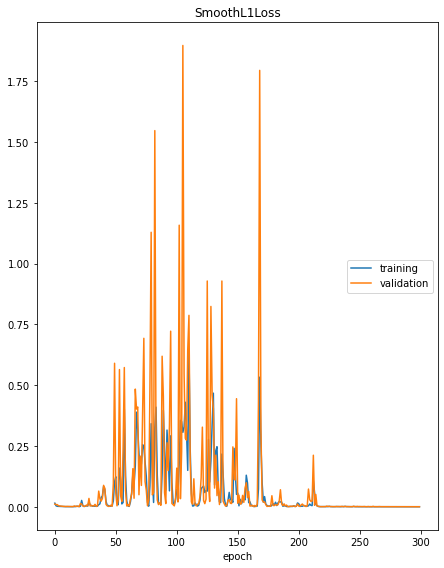

Epoch[300/300]: 100%|██████████| 300/300 [00:50<00:00,  5.95it/s, SmoothL1Loss=0.000143, MAE=3.15, MSE=16.1, RegLoss=0, MAE_val=4.14, MSE_val=28, SmoothL1Loss_val=0.000249]


In [144]:
stats
m.fit(
    df,
    freq=freq,
    validate_each_epoch=True,
    plot_live_loss=True,
    epochs=300
)

In [145]:
output

[     SmoothL1Loss         MAE            MSE  RegLoss  SmoothL1Loss_val  \
 0        0.967677  329.616606  166929.061074      0.0          0.010940   
 1        0.846130  299.843042  135879.707282      0.0          0.008971   
 2        0.738700  273.457511  112155.307499      0.0          0.008728   
 3        0.622746  244.005626   90807.239757      0.0          0.004434   
 4        0.471344  205.302373   62037.968429      0.0          0.003299   
 ..            ...         ...            ...      ...               ...   
 803      0.000144    3.166348      16.224039      0.0               NaN   
 804      0.000145    3.178989      16.290484      0.0               NaN   
 805      0.000144    3.159926      16.162633      0.0               NaN   
 806      0.000144    3.158443      16.133446      0.0               NaN   
 807      0.000143    3.154285      16.108855      0.0               NaN   
 
        MAE_val      MSE_val  
 0    27.281038  1229.310669  
 1    25.793955  1008.05

In [131]:
future = m.make_future_dataframe(
    df=df[['ds', 'y', 'y1', 'y2', 'a0']], 
    regressors_df=df[['y1', 'y2', 'a0']],
    n_historic_predictions=20,
)

In [132]:
forecast = m.predict(df=future)
forecast

,ds,y,yhat1,residual1,ar1,lagged_regressor_y11,lagged_regressor_y21,trend,season_daily,future_regressors_additive,future_regressor_a0
0,1970-01-09 06:20:00,68.500000,None,NaN,None,None,None,None,None,None,None
1,1970-01-09 06:32:30,56.705905,None,NaN,None,None,None,None,None,None,None
2,1970-01-09 06:45:00,58.000000,None,NaN,None,None,None,None,None,None,None
3,1970-01-09 06:57:30,82.294095,None,NaN,None,None,None,None,None,None,None
4,1970-01-09 07:10:00,83.500000,None,NaN,None,None,None,None,None,None,None
5,1970-01-09 07:22:30,105.535534,None,NaN,None,None,None,None,None,None,None
6,1970-01-09 07:35:00,106.330127,None,NaN,None,None,None,None,None,None,None
7,1970-01-09 07:47:30,116.829629,None,NaN,None,None,None,None,None,None,None
8,1970-01-09 08:00:00,117.000000,None,NaN,None,None,None,None,None,None,None
9,1970-01-09 08:12:30,121.829629,None,NaN,None,None,None,None,None,None,None


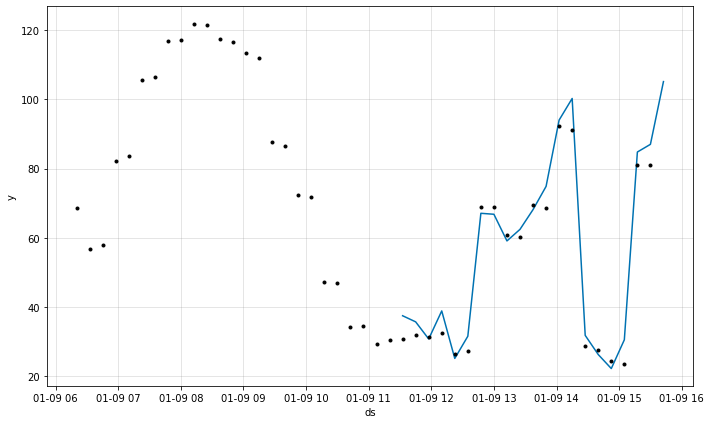

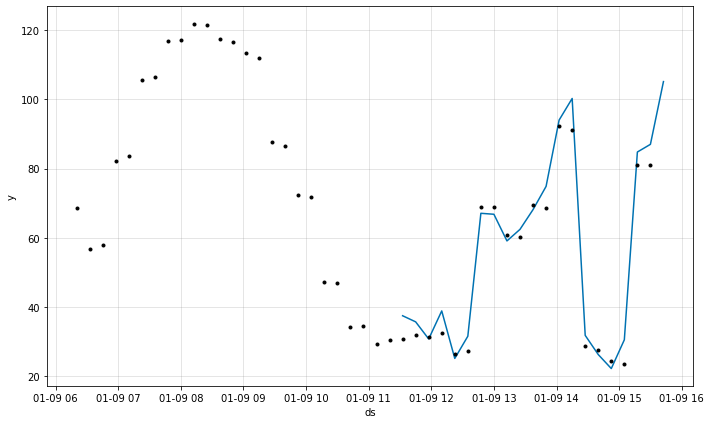

In [133]:
m.plot(forecast, )

  0%|          | 0/200 [00:00<?, ?it/s]

infering freq param as 750S
y: (97, 3)
k: 3
a: (100, 1)
t: (100,)
e: None
freq: 750S


Epoch[400/400]: 100%|██████████| 400/400 [00:07<00:00, 50.91it/s, SmoothL1Loss=0.000201, MAE=2.8, MSE=12.2, RegLoss=0]  


  0%|          | 0/200 [00:00<?, ?it/s]

df (97, 5)
df data              y          y1          y2        a0                  ds
0   264.669873  227.276173  232.034362 -0.965926 1970-01-01 00:00:00
1   226.170371  229.530814  229.543223 -0.866025 1970-01-01 00:12:30
2   226.000000  205.988065  196.604353 -0.707107 1970-01-01 00:25:00
3   193.170371  184.276311  193.407658 -0.500000 1970-01-01 00:37:30
4   193.669873  200.751554  209.703550 -0.258819 1970-01-01 00:50:00
..         ...         ...         ...       ...                 ...
92   91.000000   33.723914   37.237257 -0.707107 1970-01-01 19:10:00
93   28.705905   28.245135   31.454083 -0.866025 1970-01-01 19:22:30
94   27.500000   25.072312   37.099523 -0.965926 1970-01-01 19:35:00
95   24.464466   30.110091   24.188455 -1.000000 1970-01-01 19:47:30
96   23.669873   88.472800  101.272905 -0.965926 1970-01-01 20:00:00

[97 rows x 5 columns]
a_cols ['a0']
a_shorter (100, 1)
future (4, 7)
future data                    ds          y        y1        y2        a0         

Epoch[400/400]: 100%|██████████| 400/400 [00:08<00:00, 48.78it/s, SmoothL1Loss=0.00024, MAE=3.19, MSE=14.6, RegLoss=0] 


forecast                    ds          y    yhat1 residual1       ar1  \
0 1970-01-01 19:35:00  27.500000     None       NaN      None   
1 1970-01-01 19:47:30  24.464466     None       NaN      None   
2 1970-01-01 20:00:00  23.669873     None       NaN      None   
3 1970-01-01 20:12:30        NaN  82.9629       NaN -0.364607   

  lagged_regressor_y11 lagged_regressor_y21 lagged_regressor_a01    trend  
0                 None                 None                 None     None  
1                 None                 None                 None     None  
2                 None                 None                 None     None  
3              53.5126              22.1563             0.427308  7.23131  
forecast1                    ds          y    yhat1 residual1       ar1  \
0 1970-01-01 19:35:00  27.500000     None       NaN      None   
1 1970-01-01 19:47:30  24.464466     None       NaN      None   
2 1970-01-01 20:00:00  23.669873     None       NaN      None   
3 1970-01-01 20

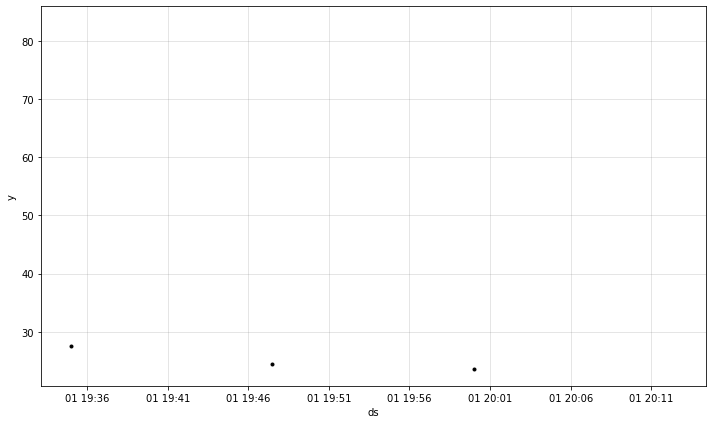

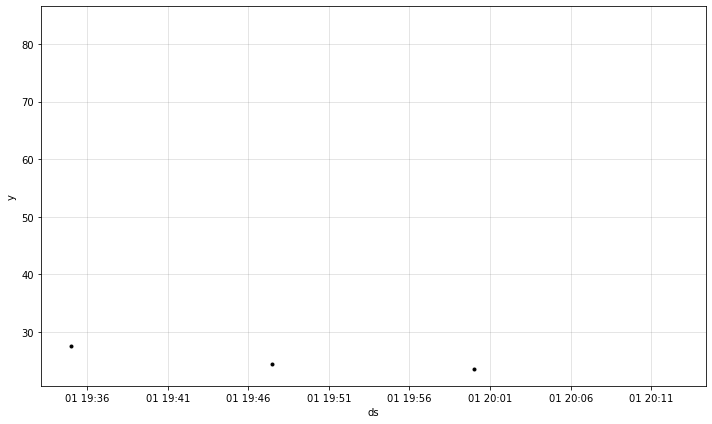

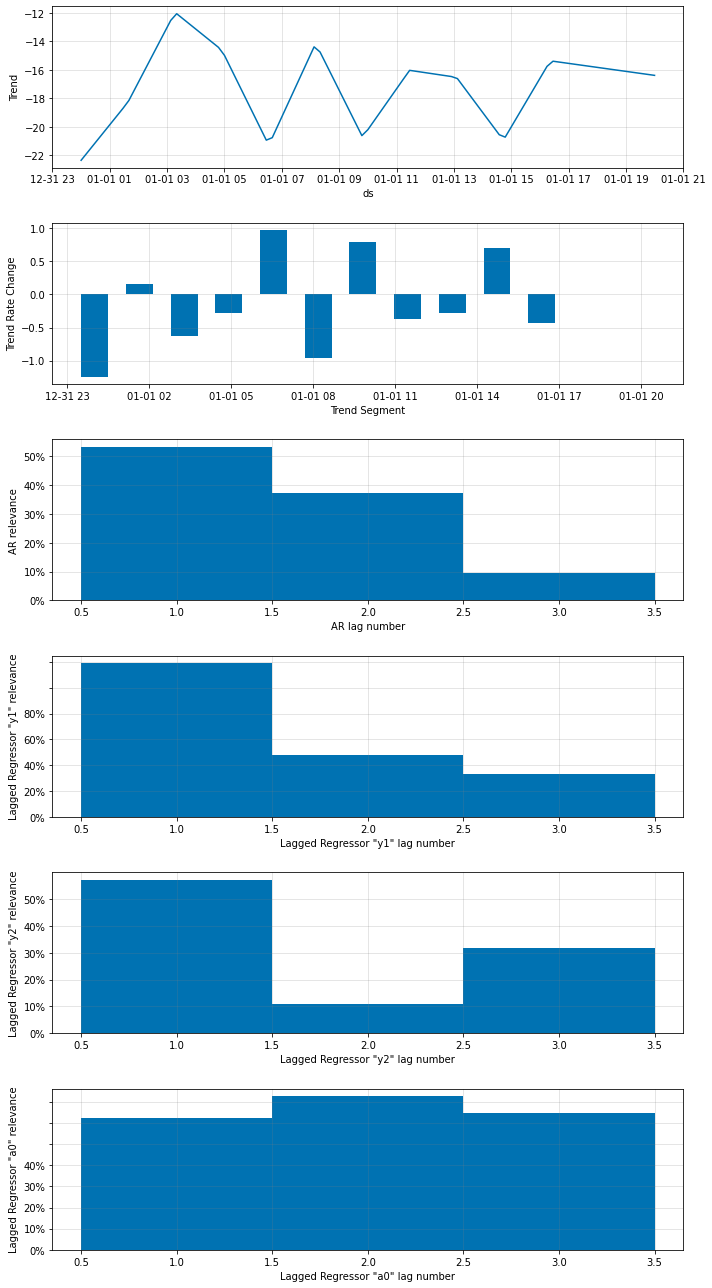

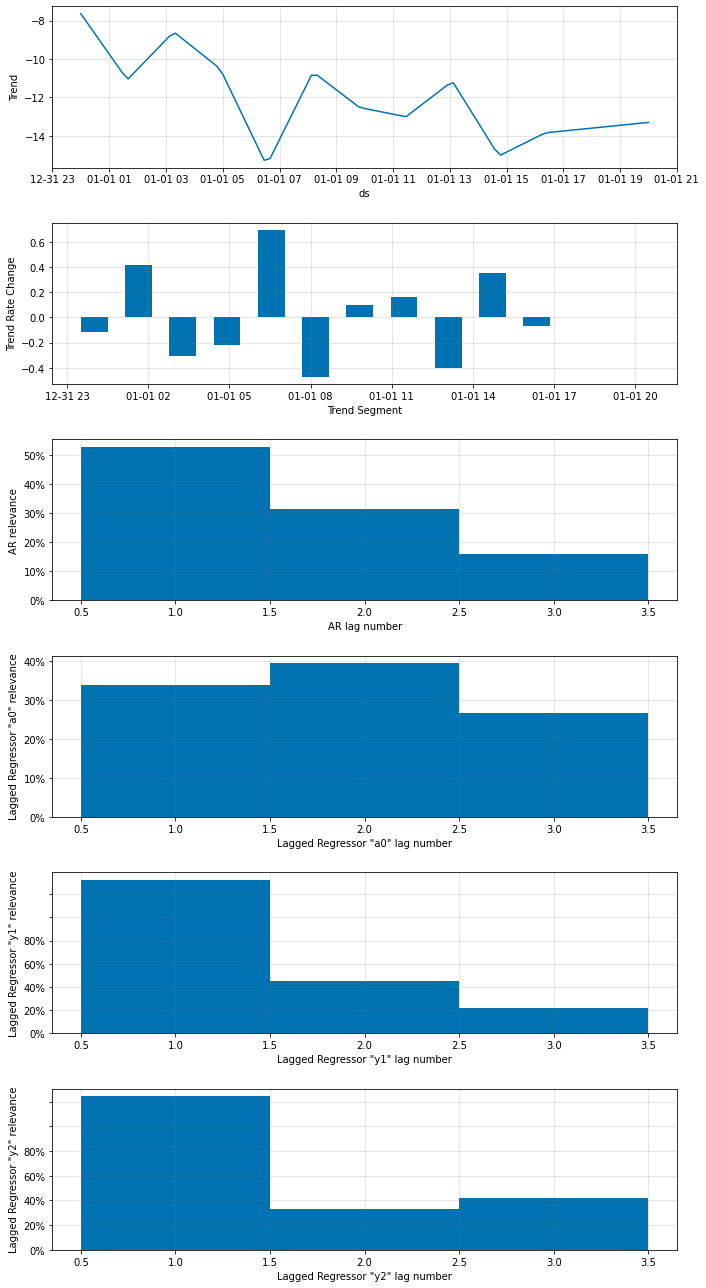

In [14]:
k = 3
n = 100
y, a = hospital_with_exog(k=k, n=n)
y = y[:-k]
t = [i * 15 * 50 for i in range(len(y) + k)]
x, x_std, forecast, m = nprophet_iskater_factory(y=y, k=k, t=t, a=a,)
assert len(x) == k
x1, x_std1, forecast1, m1 = \
    nprophet_fit_and_predict_with_exog_and_advance_vars(y=y, k=k, t=t, a=a)
# assert nearlysame(x1, x, 0.0001)

print('forecast', forecast)
print('forecast1', forecast1)
m.plot(forecast)
m1.plot(forecast1)
m.plot_parameters()
m1.plot_parameters()
import matplotlib.pyplot as plt
plt.show()